# Neural Network from Scratch


In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [4]:
A = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
], dtype=np.float32)

B = np.array([
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,0],
], dtype=np.float32)

C = np.array([
    [0,1,1,1,1],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,1,1,1,1],
], dtype=np.float32)

def img_to_vector(img):
    return img.flatten()

X_base = np.vstack([img_to_vector(A), img_to_vector(B), img_to_vector(C)])  
y_base = np.array([0,1,2])

In [5]:
def augment_data(X, y, n_copies=100, flip_prob=0.03):
    N, D = X.shape
    X_aug, y_aug = [], []
    for i in range(N):
        for _ in range(n_copies):
            vec = X[i].copy()
            mask = np.random.rand(D) < flip_prob
            vec[mask] = 1 - vec[mask]
            X_aug.append(vec)
            y_aug.append(y[i])
    return np.vstack(X_aug), np.array(y_aug, dtype=int)

X_aug, y_aug = augment_data(X_base, y_base, n_copies=700, flip_prob=0.03)
X_train = np.vstack([X_aug, X_base.repeat(20, axis=0)])
y_train = np.concatenate([y_aug, y_base.repeat(20)])

print("Training set shape:", X_train.shape, y_train.shape)

Training set shape: (2160, 30) (2160,)


In [6]:
def sigmoid(z): return 1 / (1 + np.exp(-z))
def sigmoid_deriv(a): return a * (1 - a)
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)
def cross_entropy_loss(probs, labels_onehot):
    N = probs.shape[0]
    p = np.clip(probs, 1e-12, 1.0)
    return -np.sum(labels_onehot * np.log(p)) / N
def accuracy(probs, labels):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == labels)

In [7]:
input_dim, hidden_dim, output_dim = 30, 16, 3
def xavier_init(in_dim, out_dim):
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, size=(in_dim, out_dim)).astype(np.float32)

W1 = xavier_init(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim), dtype=np.float32)
W2 = xavier_init(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim), dtype=np.float32)

In [8]:
def to_onehot(y, C):
    one = np.zeros((len(y), C), dtype=np.float32)
    one[np.arange(len(y)), y] = 1.0
    return one

y_train_oh = to_onehot(y_train, output_dim)

In [9]:
lr, epochs, batch_size = 0.5, 1000, 128
history = {"loss": [], "acc": []}
N = X_train.shape[0]

for epoch in range(1, epochs + 1):
    perm = np.random.permutation(N)
    X_train, y_train_oh, y_train = X_train[perm], y_train_oh[perm], y_train[perm]
    
    for i in range(0, N, batch_size):
        X_batch, y_batch_oh = X_train[i:i+batch_size], y_train_oh[i:i+batch_size]
        y_batch_labels = y_train[i:i+batch_size]
        
        z1 = X_batch.dot(W1) + b1
        a1 = sigmoid(z1)
        z2 = a1.dot(W2) + b2
        probs = softmax(z2)

        B = X_batch.shape[0]
        dz2 = (probs - y_batch_oh) / B
        dW2 = a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2.dot(W2.T)
        dz1 = da1 * sigmoid_deriv(a1)
        dW1 = X_batch.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        W2 -= lr * dW2; b2 -= lr * db2
        W1 -= lr * dW1; b1 -= lr * db1

    z1_full = X_train.dot(W1) + b1
    a1_full = sigmoid(z1_full)
    z2_full = a1_full.dot(W2) + b2
    probs_full = softmax(z2_full)
    loss, acc = cross_entropy_loss(probs_full, y_train_oh), accuracy(probs_full, y_train)
    history["loss"].append(loss); history["acc"].append(acc)
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}  Loss: {loss:.4f}  Acc: {acc*100:.2f}%")

Epoch    1  Loss: 0.4174  Acc: 100.00%
Epoch  100  Loss: 0.0009  Acc: 100.00%
Epoch  200  Loss: 0.0004  Acc: 100.00%
Epoch  300  Loss: 0.0003  Acc: 100.00%
Epoch  400  Loss: 0.0002  Acc: 100.00%
Epoch  500  Loss: 0.0002  Acc: 100.00%
Epoch  600  Loss: 0.0001  Acc: 100.00%
Epoch  700  Loss: 0.0001  Acc: 100.00%
Epoch  800  Loss: 0.0001  Acc: 100.00%
Epoch  900  Loss: 0.0001  Acc: 100.00%
Epoch 1000  Loss: 0.0001  Acc: 100.00%


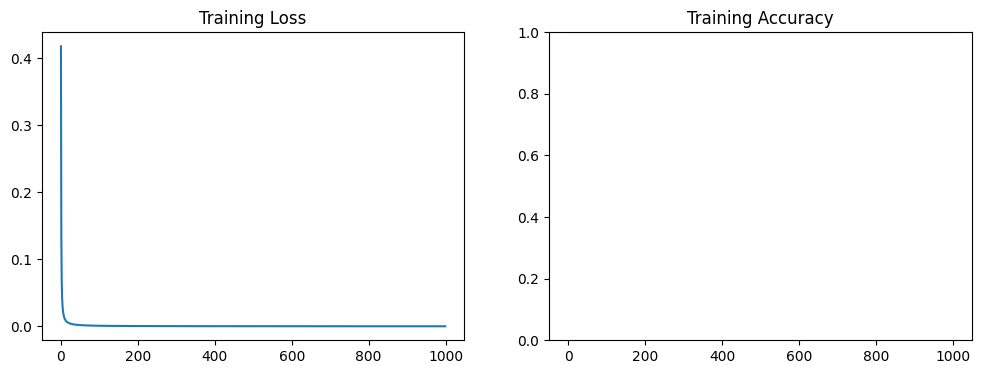

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["loss"]); plt.title("Training Loss")
plt.subplot(1,2,2)
plt.plot(history["acc"]); plt.title("Training Accuracy"); plt.ylim(0,1)
plt.show()

Predictions: [0 1 2]
Probabilities:
 [[9.9996436e-01 1.6674130e-05 1.8976718e-05]
 [1.3919422e-05 9.9996161e-01 2.4451512e-05]
 [1.2902699e-05 1.7703996e-05 9.9996936e-01]]


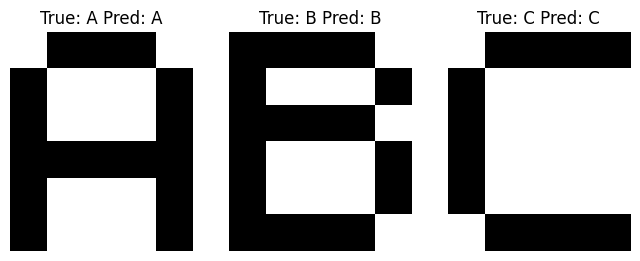

In [11]:
def predict(X):
    z1 = X.dot(W1) + b1
    a1 = sigmoid(z1)
    z2 = a1.dot(W2) + b2
    return softmax(z2)

test_X = X_base
probs, preds = predict(test_X), np.argmax(predict(test_X), axis=1)
print("Predictions:", preds)
print("Probabilities:\n", probs)

labels = ['A','B','C']
plt.figure(figsize=(8,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_X[i].reshape(6,5), cmap='gray_r')
    plt.title(f"True: {labels[i]} Pred: {labels[preds[i]]}")
    plt.axis('off')
plt.show()